In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
warnings.filterwarnings("ignore")
%matplotlib inline

# Load Data

In [3]:
airline_df = pd.read_csv('./Dataset/international-airline-passengers.csv')

In [4]:
airline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


# Feature Extraction

In [5]:
airline_df['Date'] = pd.to_datetime(airline_df['Date'])
airline_df['year'] = airline_df.Date.dt.year
airline_df['month'] = airline_df.Date.dt.month
airline_df['quarter'] = airline_df.Date.dt.quarter

In [6]:
airline_df.index = airline_df['Date']
airline_df.head(10)

,Date,Passengers,year,month,quarter
Date,,,,,
1949-01-01,1949-01-01,112,1949,1,1
1949-02-01,1949-02-01,118,1949,2,1
1949-03-01,1949-03-01,132,1949,3,1
1949-04-01,1949-04-01,129,1949,4,2
1949-05-01,1949-05-01,121,1949,5,2
1949-06-01,1949-06-01,135,1949,6,2
1949-07-01,1949-07-01,148,1949,7,3
1949-08-01,1949-08-01,148,1949,8,3
1949-09-01,1949-09-01,136,1949,9,3


# Exploratory Data Analysis

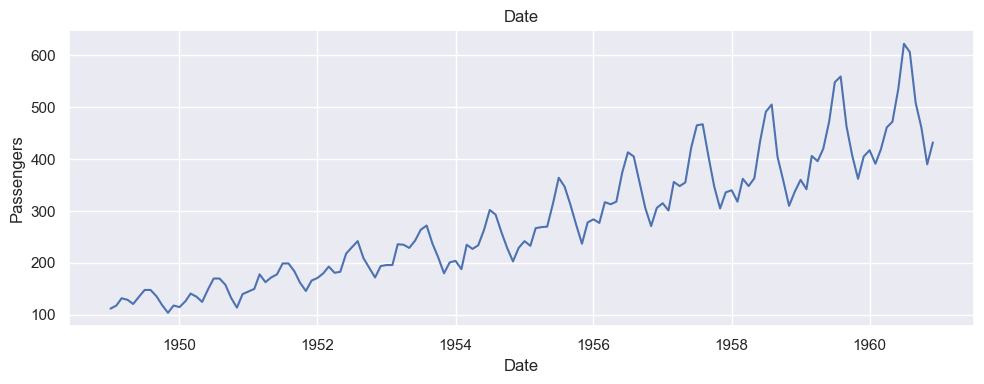

In [7]:
plt.figure(figsize=(10,4))
sns.lineplot(airline_df['Passengers'])
plt.title("Date")
plt.tight_layout()
plt.show()

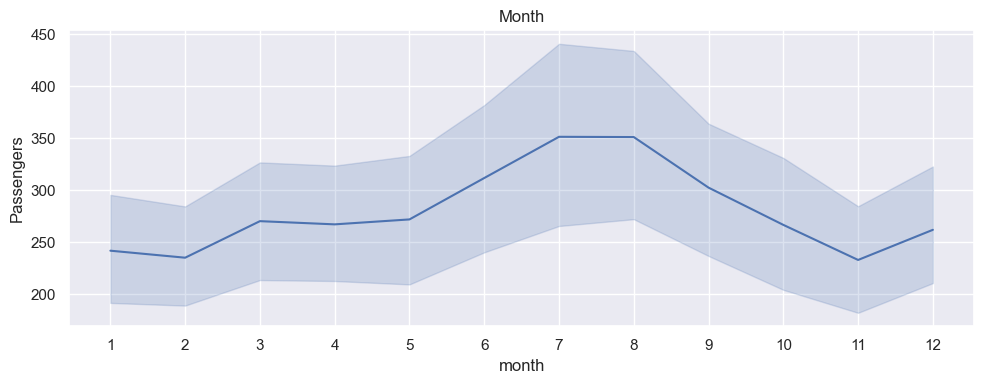

In [8]:
plt.figure(figsize=(10,4))
sns.lineplot(x='month', y='Passengers', data=airline_df)
plt.title("Month")
plt.xticks(np.arange(1, 13))
plt.tight_layout()
plt.show()

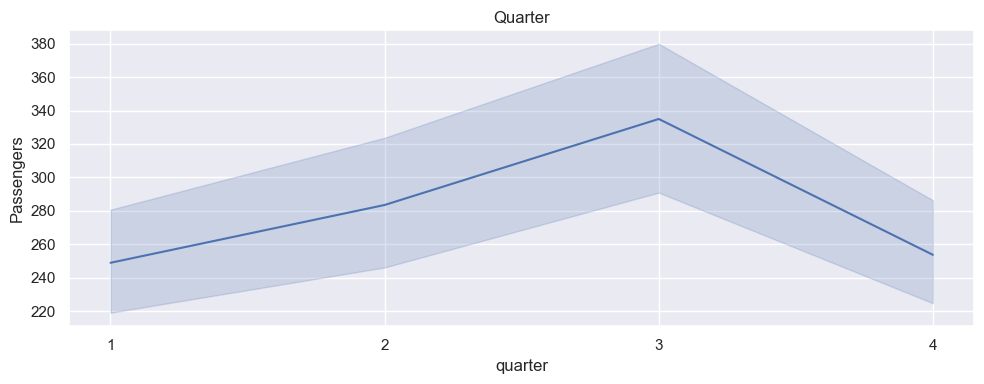

In [9]:
plt.figure(figsize=(10,4))
sns.lineplot(x='quarter', y='Passengers', data=airline_df)
plt.title("Quarter")
plt.xticks(np.arange(1, 5))
plt.tight_layout()
plt.show()

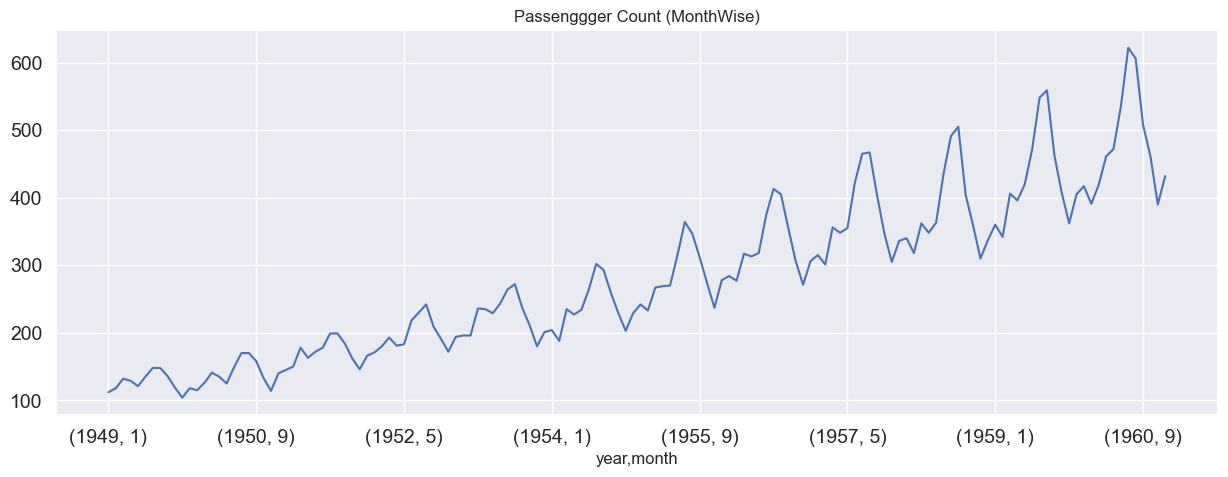

In [10]:
month_group = airline_df.groupby(['year','month'])['Passengers'].mean()
month_group.plot(figsize=(15,5), title='Passenggger Count (MonthWise)', fontsize=14)
plt.show()

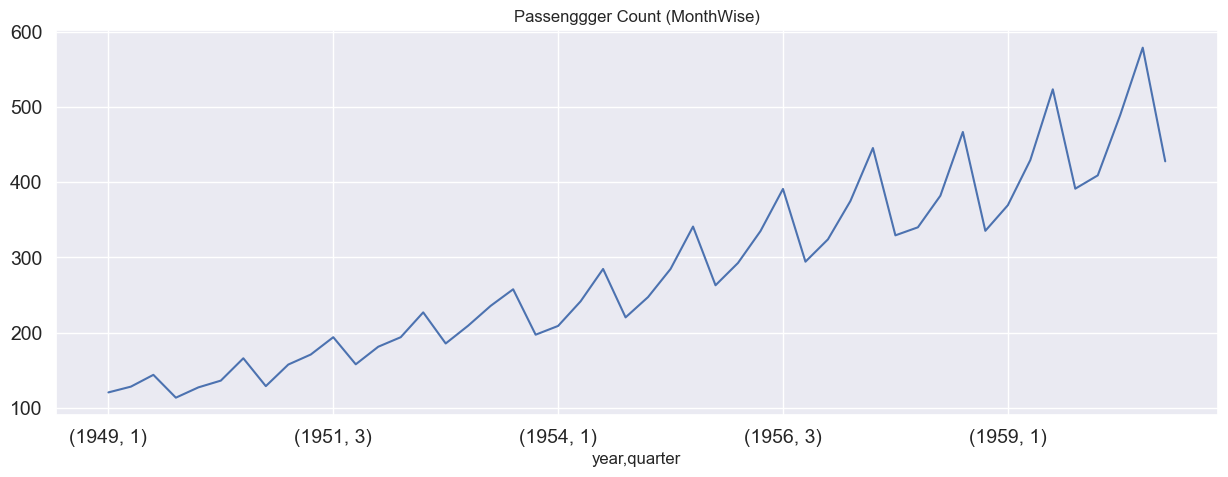

In [11]:
quarter_group = airline_df.groupby(['year','quarter'])['Passengers'].mean()
quarter_group.plot(figsize=(15,5), title='Passenggger Count (MonthWise)', fontsize=14)
plt.show()

# Forecasting Modelling

In [12]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
airline_final = airline_df.drop(['Date','year','month','quarter'], axis=1)

## Standar Moving Averange

In [13]:
# Standar Moving Averange
airline_sma = airline_final.copy()
airline_sma['3-month-SMA'] = airline_sma['Passengers'].rolling(window=4).mean()
airline_sma['12-month-SMA'] = airline_sma['Passengers'].rolling(window=12).mean()
airline_sma.head()

,Passengers,3-month-SMA,12-month-SMA
Date,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,122.75,NaN
1949-05-01,121,125.00,NaN


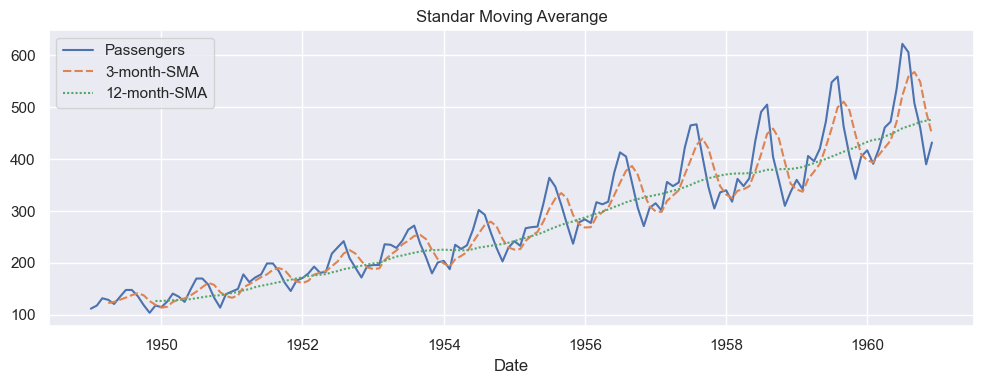

In [14]:
plt.figure(figsize=(10,4))
sns.lineplot(data=airline_sma)
plt.title("Standar Moving Averange")
plt.tight_layout()
plt.show()

## Simple Exponential Smoothing

In [14]:
# Simple Exponential Smoothing
airline_ses = airline_final.copy()

train_data_ses = airline_ses.loc['1949-01-01':'1958-12-01']
test_data_ses = airline_ses.loc['1959-01-01':'1960-12-01']

In [15]:
model_ses = SimpleExpSmoothing(np.array(train_data_ses['Passengers']))
fitted_model_ses1 = model_ses.fit(smoothing_level=0.3, use_brute=True, optimized=False)
train_data_ses['alpha-0.3'] = fitted_model_ses1.fittedvalues

fitted_model_ses2 = model_ses.fit(smoothing_level=0.8, use_brute=True, optimized=False)
train_data_ses['alpha-0.8'] = fitted_model_ses2.fittedvalues

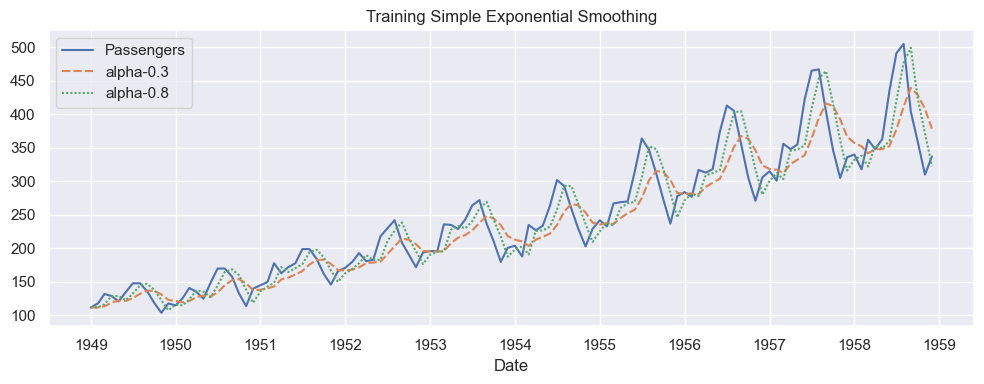

In [16]:
plt.figure(figsize=(10,4))
sns.lineplot(data=train_data_ses)
plt.title("Training Simple Exponential Smoothing")
plt.tight_layout()
plt.show()

In [17]:
start = len(train_data_ses)
end = len(train_data_ses)+len(test_data_ses)-1

test_data_ses['alpha-0.3'] = fitted_model_ses1.predict(start, end)
test_data_ses['alpha-0.8'] = fitted_model_ses2.predict(start, end)

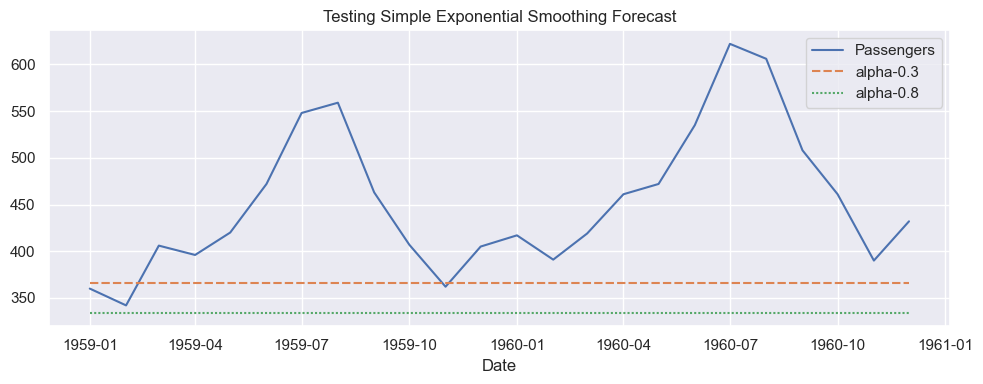

In [18]:
plt.figure(figsize=(10,4))
sns.lineplot(data=test_data_ses)
plt.title("Testing Simple Exponential Smoothing Forecast")
plt.tight_layout()
plt.show()

## Exponential Smoothing

In [20]:
# Exponential Smoothing Predict/Forecast
airline_data_es = airline_final.copy()
train_data_es = airline_data_es.loc['1949-01-01':'1958-12-01']
test_data_es = airline_data_es.loc['1959-01-01':'1960-12-01']

In [21]:
fitted_model = ExponentialSmoothing(
    np.array(train_data_es['Passengers']), 
    trend='add', 
    seasonal_periods=12, 
    seasonal='add'
).fit()

In [23]:
fitted_model.params

{'smoothing_level': 0.23678678235712566,
 'smoothing_trend': 1.8055668382578714e-09,
 'smoothing_seasonal': 0.7632132086415252,
 'damping_trend': nan,
 'initial_level': 119.1876680939318,
 'initial_trend': 2.2768394955266533,
 'initial_seasons': array([ -9.42424719,  -3.87104168,   8.69002781,   3.6678027 ,
         -4.94701962,   9.26652064,  21.53444859,  19.2001798 ,
          5.07181472, -13.80997707, -28.51179942, -12.37245268]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [24]:
train_data_es['y_hat'] = fitted_model.fittedvalues

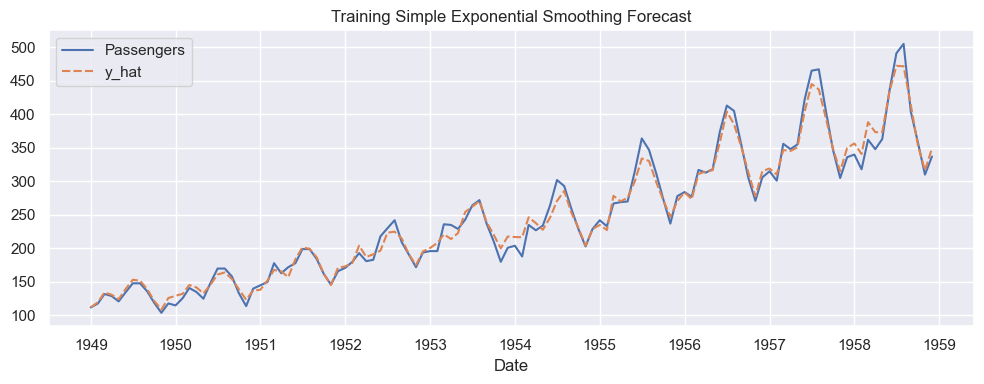

In [25]:
plt.figure(figsize=(10,4))
sns.lineplot(train_data_es)
plt.title("Training Simple Exponential Smoothing Forecast")
plt.tight_layout()
plt.show()

In [26]:
test_data_es['y_hat'] = fitted_model.forecast(len(test_data_es))

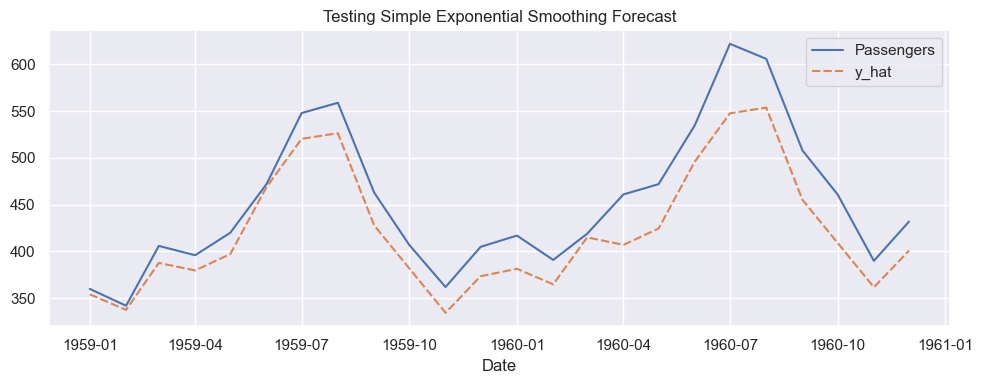

In [27]:
plt.figure(figsize=(10,4))
sns.lineplot(test_data_es)
plt.title("Testing Simple Exponential Smoothing Forecast")
plt.tight_layout()
plt.show()

## ARIMA

In [91]:
train_data = airline_final.loc['1949-01-01':'1958-12-01']
test_data = airline_final.loc['1959-01-01':'1960-12-01']

In [118]:
model = ARIMA(np.array(train_data['Passengers']), order=(2,1,2))
model_fit = model.fit()

In [119]:
start = len(train_data)
end = len(train_data)+len(test_data)-1

test_data['ARIMA Forecast'] = model_fit.predict(start, end, dynamic=True)

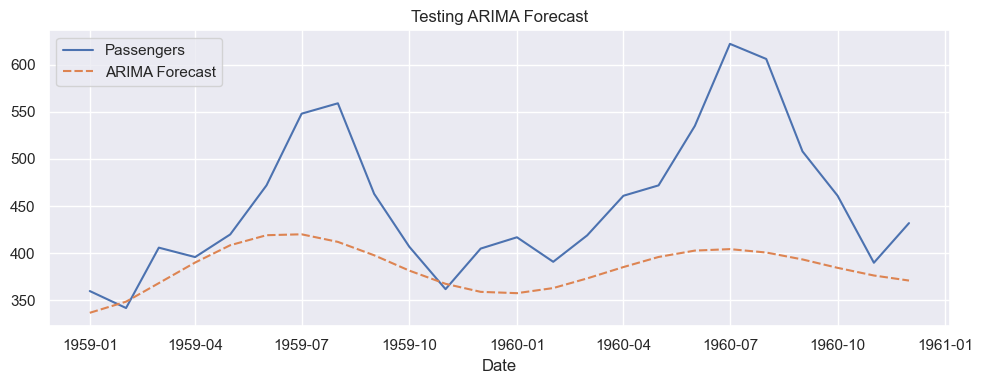

In [120]:
plt.figure(figsize=(10,4))
sns.lineplot(test_data)
plt.title("Testing ARIMA Forecast")
plt.tight_layout()
plt.show()

## SARIMAX

In [86]:
train_data = airline_final.loc['1949-01-01':'1958-12-01']
test_data = airline_final.loc['1959-01-01':'1960-12-01']

In [87]:
model = SARIMAX(np.array(train_data['Passengers']), seasonal_order=(1,1,1,12))
result = model.fit()

In [88]:
start = len(train_data)
end = len(train_data)+len(test_data)-1

test_data['SARIMAX Forecast'] = result.predict(start, end, typ='levels')

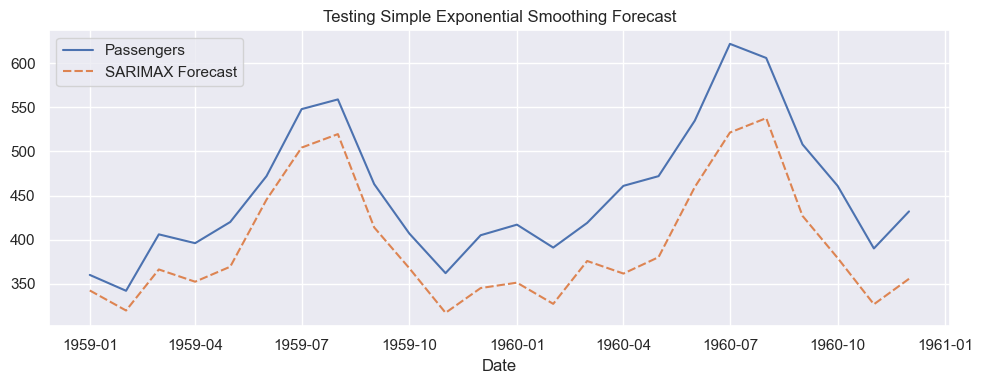

In [90]:
plt.figure(figsize=(10,4))
sns.lineplot(test_data)
plt.title("Testing Simple Exponential Smoothing Forecast")
plt.tight_layout()
plt.show()